<a href="https://colab.research.google.com/github/jesicha24001-ship-it/klasifikasi-credit-smote-nc-dan-bo/blob/main/Smote_nc_0_8_%2B_Bayesian_Optimasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===================================================================================
TESIS: KLASIFIKASI KELAYAKAN KREDIT DENGAN SMOTE-NC DAN BAYESIAN OPTIMIZATION (v8.1)
===================================================================================
Author: Jesicha Aulia Adam (diperbarui oleh assistant)
Version: 8.1 - Show BO iterations + BO for LR/Ada/XGB + fixed_sampling=0.8
Date: November 2025

Perubahan utama:
- fixed_sampling_strategy default = 0.8 (lebih konservatif dari 1.0)
- Bayesian Optimization diterapkan pada LogisticRegression, AdaBoost, XGBoost
- Menampilkan setiap iterasi BO (params + target)
- Objective BO menggunakan Stratified 3-fold CV pada data yang sudah di-resample (SMOTENC)
- Ringkasan hasil tiap model disimpan ke CSV
===================================================================================
"""

# ===================================================================================
# IMPORT LIBRARIES
# ===================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
from datetime import datetime

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score,
    precision_score, f1_score, roc_auc_score,
    roc_curve, average_precision_score, make_scorer
)
from sklearn.base import clone
from sklearn.utils import check_random_state

# XGBoost
try:
    from xgboost import XGBClassifier
except ImportError:
    print("❌ XGBoost tidak terinstal. Install dengan: pip install xgboost")
    sys.exit(1)

# Imbalanced-learn
try:
    from imblearn.over_sampling import SMOTENC
    from imblearn.metrics import geometric_mean_score
    from imblearn.pipeline import Pipeline as ImbPipeline
except ImportError:
    print("❌ Imbalanced-learn tidak terinstal. Install dengan: pip install imbalanced-learn")
    sys.exit(1)

# Bayesian Optimization
try:
    # Install if not present
    %pip install bayesian-optimization
    from bayes_opt import BayesianOptimization
except ImportError:
    print("❌ Bayesian Optimization tidak terinstal. Install dengan: pip install bayesian-optimization")
    sys.exit(1)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create results directory
if not os.path.exists('results'):
    os.makedirs('results')

# ===================================================================================
# KONFIGURASI
# ===================================================================================

CONFIG = {
    'data_file': '/content/Data bank sulteng 2 TESIS.csv', # Changed to user's file
    'test_size': 0.3,
    'random_state': 42,
    'bo_init_points': 5,
    'bo_n_iter': 20,
    'fixed_sampling_strategy': 0.8,  # <-- perubahan: jadi 0.8 (variasi konservatif)
    'smote_k_range': (3, 7),
    'results_dir': 'results/'
}

# ===================================================================================
# UTILITY FUNCTIONS
# ===================================================================================

def print_header(text, width=90):
    print("\n" + "="*width)
    print(text.center(width))
    print("="*width)

def print_subheader(text):
    print(f"\n{'='*90}")
    print(f">>> {text}")
    print(f"{'='*90}")

def find_column(df, possible_names):
    df_cols_lower = [col.lower().strip() for col in df.columns]
    for name in possible_names:
        if name.lower().strip() in df_cols_lower:
            idx = df_cols_lower.index(name.lower().strip())
            return df.columns[idx]
    return None

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    # protect if confusion matrix not 2x2
    if cm.size == 1:
        # Edge case: only one class predicted
        tn = cm.flat[0]
        fp = fn = tp = 0
    else:
        tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    # geometric_mean_score requires imblearn
    try:
        gmean = geometric_mean_score(y_true, y_pred)
    except Exception:
        gmean = np.nan
    if y_pred_proba is not None:
        auc_roc = roc_auc_score(y_true, y_pred_proba)
        auc_pr = average_precision_score(y_true, y_pred_proba)
    else:
        auc_roc = None
        auc_pr = None
    unique_preds = len(np.unique(y_pred))
    is_broken = unique_preds < 2
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1-Score': f1,
        'G-Mean': gmean,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr,
        'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
        'Broken': is_broken,
        'N_Classes_Predicted': unique_preds
    }, cm

def print_prediction_distribution(y_pred, y_true, model_name, target_mapping):
    pred_dist = pd.Series(y_pred).value_counts().sort_index()
    true_dist = pd.Series(y_true).value_counts().sort_index()
    print(f"\n  📊 Distribusi Prediksi vs Aktual:")
    print(f"     {'Kelas':<20} {'Aktual':<12} {'Prediksi':<12}")
    print(f"     {'-'*44}")
    for label in sorted(true_dist.index):
        actual_count = true_dist.get(label, 0)
        pred_count = pred_dist.get(label, 0)
        label_name = target_mapping.get(label, f"Kelas {label}")
        print(f"     {label_name:<20} {actual_count:<12} {pred_count:<12}")
    if len(pred_dist) < 2:
        print(f"\n     ⚠️  WARNING: Model hanya prediksi kelas {pred_dist.index[0]}!")

def plot_confusion_matrix(cm, title, target_mapping, filename=None):
    plt.figure(figsize=(8, 6))
    labels = sorted(target_mapping.keys())
    label_names = [target_mapping[l] for l in labels]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
    plt.title(title, fontsize=14, fontweight='bold', pad=15)
    plt.ylabel('Actual', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"   ✓ Confusion matrix disimpan: {filename}")
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name, filename=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random', alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold', pad=15)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"   ✓ ROC Curve disimpan: {filename}")
    plt.show()

def plot_data_distribution(y_data, title, target_mapping, filename=None, subtitle=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    dist = pd.Series(y_data).value_counts().sort_index()
    colors = ['#3498db', '#e74c3c']
    labels_names = [target_mapping[i] for i in sorted(dist.index)]
    counts = [dist[i] for i in sorted(dist.index)]
    bars = ax1.bar(labels_names, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('Jumlah Sampel', fontsize=12, fontweight='bold')
    ax1.set_title('Distribusi Kelas', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    ax2.pie(counts, labels=labels_names, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax2.set_title('Proporsi Kelas', fontsize=13, fontweight='bold')
    if subtitle:
        fig.suptitle(f'{title}\n{subtitle}', fontsize=15, fontweight='bold', y=1.02)
    else:
        fig.suptitle(title, fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"   ✓ Visualisasi distribusi disimpan: {filename}")
    plt.show()
    print(f"\n📊 STATISTIK DISTRIBUSI:")
    total = len(y_data)
    for label in sorted(dist.index):
        count = dist[label]
        pct = (count / total) * 100
        label_name = target_mapping[label]
        print(f"   {label_name:<20}: {count:>6} sampel ({pct:>5.1f}%)")
    if len(dist) == 2:
        ratio = dist.max() / dist.min()
        print(f"\n   Imbalance Ratio: {ratio:.2f}:1")

def print_comparison_table(results_df, title="PERBANDINGAN MODEL"):
    print(f"\n{'='*90}")
    print(f"{title:^90}")
    print(f"{'='*90}")
    metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'G-Mean', 'AUC-ROC']
    print(f"\n{'Model':<45}", end='')
    for metric in metrics:
        print(f"{metric:>12}", end='')
    print()
    print("-" * 139)
    for _, row in results_df.iterrows():
        print(f"{row['Model']:<45}", end='')
        for metric in metrics:
            if pd.notna(row[metric]):
                print(f"{row[metric]:>12.4f}", end='')
            else:
                print(f"{'N/A':>12}", end='')
        print()

def save_results_to_csv(results_list, filename):
    df = pd.DataFrame(results_list)
    filepath = os.path.join(CONFIG['results_dir'], filename)
    df.to_csv(filepath, index=False)
    print(f"✓ Results saved: {filepath}")
    return df

# ===================================================================================
# HELPERS FOR BAYESIAN OBJECTIVES
# ===================================================================================

# make a scorer wrapper for geometric_mean_score to use in cross_val_score
gmean_scorer = make_scorer(lambda y_true, y_pred: geometric_mean_score(y_true, y_pred), greater_is_better=True)

def cv_score_on_resampled(model, X_res, y_res, cv_splits=3, random_state=None):
    """Compute CV mean g-mean on resampled data with StratifiedKFold"""
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    try:
        scores = cross_val_score(model, X_res, y_res, scoring=gmean_scorer, cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        return 0.0

# ===================================================================================
# MAIN EXECUTION
# ===================================================================================

if __name__ == "__main__":

    start_time = datetime.now()
    print_header("TESIS: KLASIFIKASI KELAYAKAN KREDIT")
    print(" "*20 + "Fixed Sampling Strategy + Bayesian Optimization (v8.1)")
    print(" "*32 + "VERSION 8.1")
    print(" "*28 + f"Started: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

    # -------------------------------------------------------------------------------
    # STEP 1: LOAD DATA
    # -------------------------------------------------------------------------------
    print_header("STEP 1: LOAD DATA")
    try:
        # FIX: Changed 'sep=;' to 'sep=,' for proper CSV parsing
        df = pd.read_csv(CONFIG['data_file'], sep=';') # Reverted to semicolon separator for user's file
        print(f"\n✓ Dataset berhasil dimuat: {CONFIG['data_file']}")
        print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    except FileNotFoundError:
        print(f"\n❌ Error: File '{CONFIG['data_file']}' tidak ditemukan!")
        sys.exit(1)
    except Exception as e:
        print(f"\n❌ Error saat load data: {e}")
        sys.exit(1)

    print(f"\n📋 Kolom Dataset:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col} ({df[col].dtype})")


                           TESIS: KLASIFIKASI KELAYAKAN KREDIT                            
                    Fixed Sampling Strategy + Bayesian Optimization (v8.1)
                                VERSION 8.1
                            Started: 2026-01-11 08:17:02

                                    STEP 1: LOAD DATA                                     

✓ Dataset berhasil dimuat: /content/Data bank sulteng 2 TESIS.csv
  Shape: 1448 rows × 8 columns

📋 Kolom Dataset:
   1. No (int64)
   2. Y (object)
   3. X1 (object)
   4. X2 (object)
   5. X3 (int64)
   6. X4 (int64)
   7. X5 (int64)
   8. X6 (object)


In [5]:
print(f"Kolom Target: {target_col}")
print(f"\nFitur Kategorikal: {categorical_features}")
print(f"\nFitur Numerik: {numerical_features}")

Kolom Target: Y

Fitur Kategorikal: ['X1', 'X2', 'X6']

Fitur Numerik: ['No', 'X3', 'X4', 'X5']


In [6]:
import os
print('Files in /content/ directory:')
for file in os.listdir('/content/'):
    print(f'- {file}')

Files in /content/ directory:
- .config
- results
- Data bank sulteng 2 TESIS.csv
- sample_data


Pada tahapan ini dapat diketahui bahwa pada dataset kelayakan kredit nasabah  memiliki beberapa tipe data, seperti object dan int64. Data dengan tipe object mengartikan bahwa data tersebut bersifat kategorikal yang bersifat kategori atau teks, yaitu Status Kredit (Y), Pendidikan (X1), Jenis Pekerjaan (X2), dan Gender (X6). Tipe data int64 bersifat numerik dengan bentuk data bilangan bulat, yaitu Umur (X3), Durasi Peminjaman (X4), dan Jumlah Tanggungan (X5).

In [4]:

    # -------------------------------------------------------------------------------
    # STEP 2: PREPROCESSING
    # -------------------------------------------------------------------------------
    print_header("STEP 2: DATA PREPROCESSING")
    target_col = find_column(df, ['status_kredit', 'status', 'target', 'kelayakan_kredit', 'kelayakan', 'label', 'Y'])
    if target_col is None:
        print("\n❌ Error: Kolom target tidak ditemukan!")
        sys.exit(1)
    print(f"\n✓ Kolom target teridentifikasi: '{target_col}'")

    # Missing values handling
    print(f"\n📊 Cek Missing Values:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
        print(f"\n⚠️  Ditemukan missing values. Melakukan imputasi...")
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].mode()[0], inplace=True)
        print("✓ Missing values telah di-imputasi")
    else:
        print("   ✓ Tidak ada missing values")

    # Duplicates
    n_duplicates = df.duplicated().sum()
    if n_duplicates > 0:
        print(f"\n⚠️  Ditemukan {n_duplicates} data duplikat. Menghapus...")
        df = df.drop_duplicates()
        print(f"✓ Data duplikat dihapus. Shape sekarang: {df.shape}")

    # Feature types
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    if target_col in categorical_features:
        categorical_features.remove(target_col)
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if target_col in numerical_features:
        numerical_features.remove(target_col)
    print(f"\n📋 Tipe Fitur:")
    print(f"   Kategorikal ({len(categorical_features)}): {categorical_features}")
    print(f"   Numerikal ({len(numerical_features)}): {numerical_features}")

    # Label encode categorical features
    print(f"\n⏳ Encoding fitur kategorikal...")
    df_processed = df.copy()
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"   ✓ {col}: {len(le.classes_)} kategori")

    # Encode target
    le_target = LabelEncoder()
    df_processed[target_col] = le_target.fit_transform(df[target_col])
    target_mapping = {i: label for i, label in enumerate(le_target.classes_)}
    print(f"\n✓ Target Encoding:")
    for code, label in target_mapping.items():
        count = (df_processed[target_col] == code).sum()
        pct = count / len(df_processed) * 100
        print(f"   {code} = {label:20}: {count:5} sampel ({pct:5.2f}%)")


                                STEP 2: DATA PREPROCESSING                                

✓ Kolom target teridentifikasi: 'Y'

📊 Cek Missing Values:
   ✓ Tidak ada missing values

📋 Tipe Fitur:
   Kategorikal (3): ['X1', 'X2', 'X6']
   Numerikal (4): ['No', 'X3', 'X4', 'X5']

⏳ Encoding fitur kategorikal...
   ✓ X1: 4 kategori
   ✓ X2: 2 kategori
   ✓ X6: 2 kategori

✓ Target Encoding:
   0 = Diterima            :  1183 sampel (81.70%)
   1 = Ditolak             :   265 sampel (18.30%)


Kemudian, atribut dengan tipe data object diubah ke dalam bentuk numerik untuk mempermudah proses selanjutnya. Hasil proses mengubah tipe data object menjadi numerik (int64)


                       STEP 3: SPLIT DATA (Train-Test Split 70:30)                        
   ✓ Visualisasi distribusi disimpan: results/00_dist_original.png


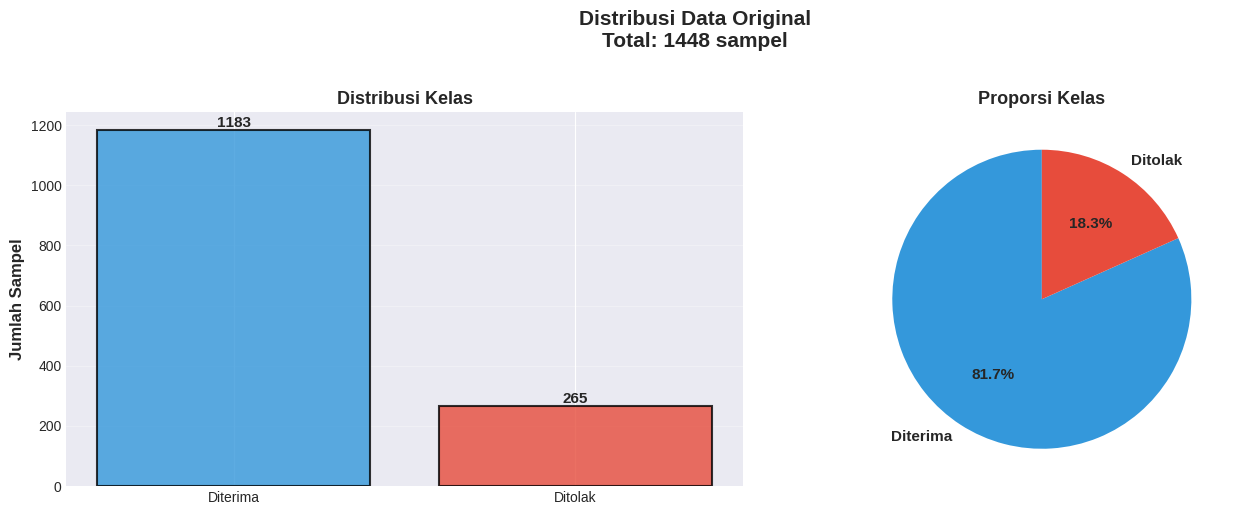


📊 STATISTIK DISTRIBUSI:
   Diterima            :   1183 sampel ( 81.7%)
   Ditolak             :    265 sampel ( 18.3%)

   Imbalance Ratio: 4.46:1

📌 Indeks fitur kategorikal untuk SMOTE-NC: [1, 2, 6]

📊 HASIL SPLIT DATA:
   Training Set:  1013 sampel (70.0%)
   Testing Set :   435 sampel (30.0%)

📊 Distribusi Kelas setelah Split:
   Kelas                    Training      Testing        Total
   --------------------------------------------------------
   Diterima                      828          355         1183
   Ditolak                       185           80          265

📊 Imbalance Ratio (Training): 4.48:1
   ✓ Visualisasi distribusi disimpan: results/00_dist_train_before_smote.png


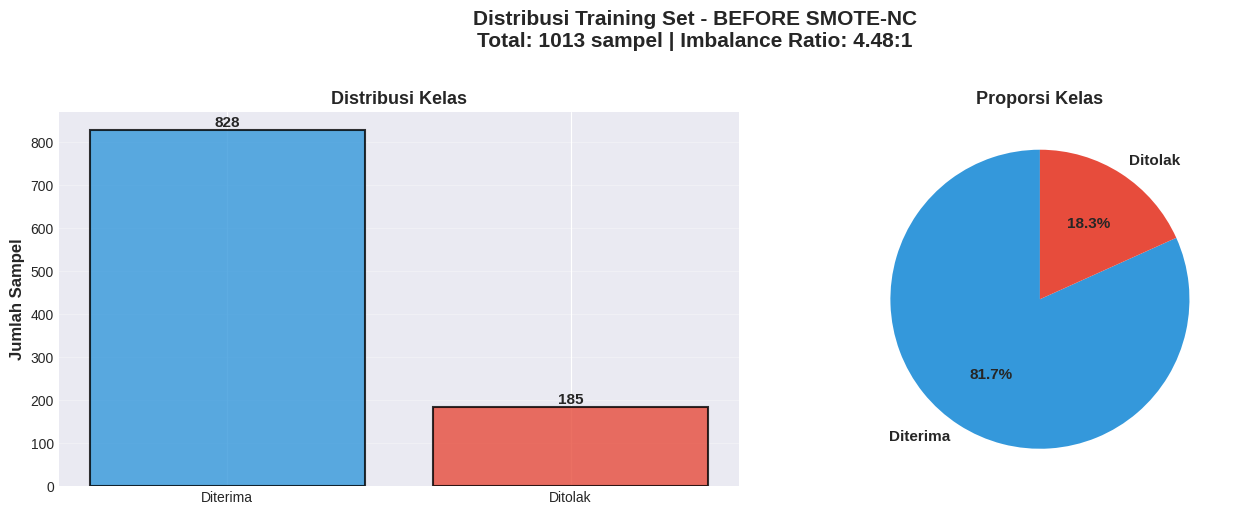


📊 STATISTIK DISTRIBUSI:
   Diterima            :    828 sampel ( 81.7%)
   Ditolak             :    185 sampel ( 18.3%)

   Imbalance Ratio: 4.48:1


In [7]:
    # -------------------------------------------------------------------------------
    # STEP 3: SPLIT + VISUALIZE
    # -------------------------------------------------------------------------------
    print_header("STEP 3: SPLIT DATA (Train-Test Split 70:30)")
    X = df_processed.drop(columns=[target_col])
    y = df_processed[target_col]

    # Visualize original
    plot_data_distribution(y, "Distribusi Data Original", target_mapping, os.path.join(CONFIG['results_dir'], '00_dist_original.png'), f"Total: {len(y)} sampel")

    # categorical indices for SMOTENC
    categorical_indices = [X.columns.get_loc(col) for col in categorical_features]
    print(f"\n📌 Indeks fitur kategorikal untuk SMOTE-NC: {categorical_indices}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=CONFIG['test_size'], random_state=CONFIG['random_state'], stratify=y)
    print(f"\n📊 HASIL SPLIT DATA:")
    print(f"   Training Set: {X_train.shape[0]:5} sampel ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"   Testing Set : {X_test.shape[0]:5} sampel ({X_test.shape[0]/len(X)*100:.1f}%)")

    train_dist = pd.Series(y_train).value_counts().sort_index()
    test_dist = pd.Series(y_test).value_counts().sort_index()
    print(f"\n📊 Distribusi Kelas setelah Split:")
    print(f"   {'Kelas':<20} {'Training':>12} {'Testing':>12} {'Total':>12}")
    print(f"   {'-'*56}")
    for label in sorted(train_dist.index):
        train_count = train_dist.get(label, 0)
        test_count = test_dist.get(label, 0)
        total_count = train_count + test_count
        label_name = target_mapping[label]
        print(f"   {label_name:<20} {train_count:>12} {test_count:>12} {total_count:>12}")

    min_class = train_dist.min()
    max_class = train_dist.max()
    ir = max_class / min_class
    print(f"\n📊 Imbalance Ratio (Training): {ir:.2f}:1")

    # Visualize train before SMOTE
    plot_data_distribution(y_train, "Distribusi Training Set - BEFORE SMOTE-NC", target_mapping, os.path.join(CONFIG['results_dir'], '00_dist_train_before_smote.png'), f"Total: {len(y_train)} sampel | Imbalance Ratio: {ir:.2f}:1")


 Pada penelitian ini digunakan proporsi 70:30. Komposisi pembagian ini mengalokasikan 70% dari total data untuk training dan 30% untuk testing.

In [8]:
# -------------------------------------------------------------------------------
# STEP 4: STANDARDIZE NUMERICAL FEATURES
# -------------------------------------------------------------------------------
print_header("STEP 4: STANDARDISASI FITUR NUMERIKAL")
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
if numerical_features:
    X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])
    print(f"\n✓ {len(numerical_features)} fitur numerikal di-standardisasi")
    print(f"   Features: {numerical_features}")
else:
    print("\n⚠️  Tidak ada fitur numerikal untuk di-standardisasi")


                          STEP 4: STANDARDISASI FITUR NUMERIKAL                           

✓ 4 fitur numerikal di-standardisasi
   Features: ['No', 'X3', 'X4', 'X5']


proses standarisasi ini hanya dilakukan di fitur numerik


                         STEP 5: BASELINE MODEL (Tanpa SMOTE-NC)                          

>>> BASELINE: Logistic Regression
   ⏳ Training model...

📊 HASIL EVALUASI (Test Set):
   Accuracy    : 0.7816
   Sensitivity : 0.3250
   Specificity : 0.8845
   Precision   : 0.3881
   F1-Score    : 0.3537
   G-Mean      : 0.5362
   AUC-ROC     : 0.8353
   AUC-PR      : 0.4011

  📊 Distribusi Prediksi vs Aktual:
     Kelas                Aktual       Prediksi    
     --------------------------------------------
     Diterima             355          368         
     Ditolak              80           67          
   ✓ Confusion matrix disimpan: results/01_cm_baseline_logistic_regression.png


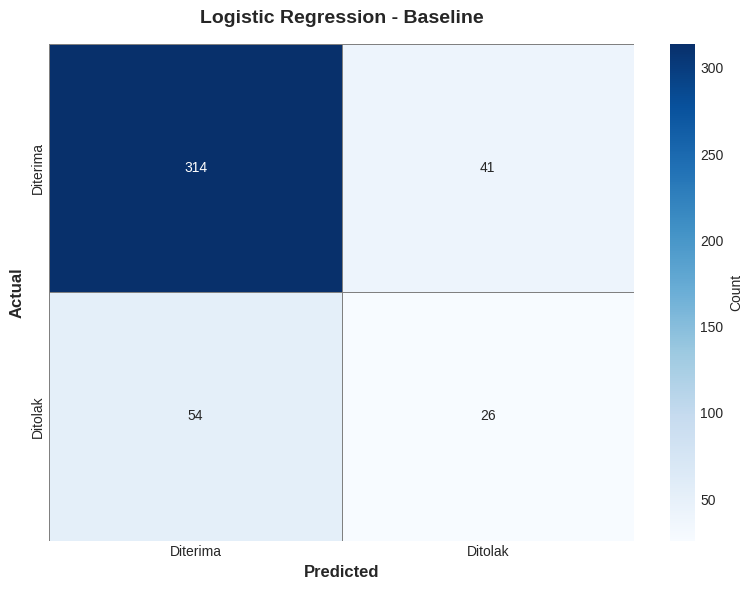

   ✓ ROC Curve disimpan: results/01_roc_baseline_logistic_regression.png


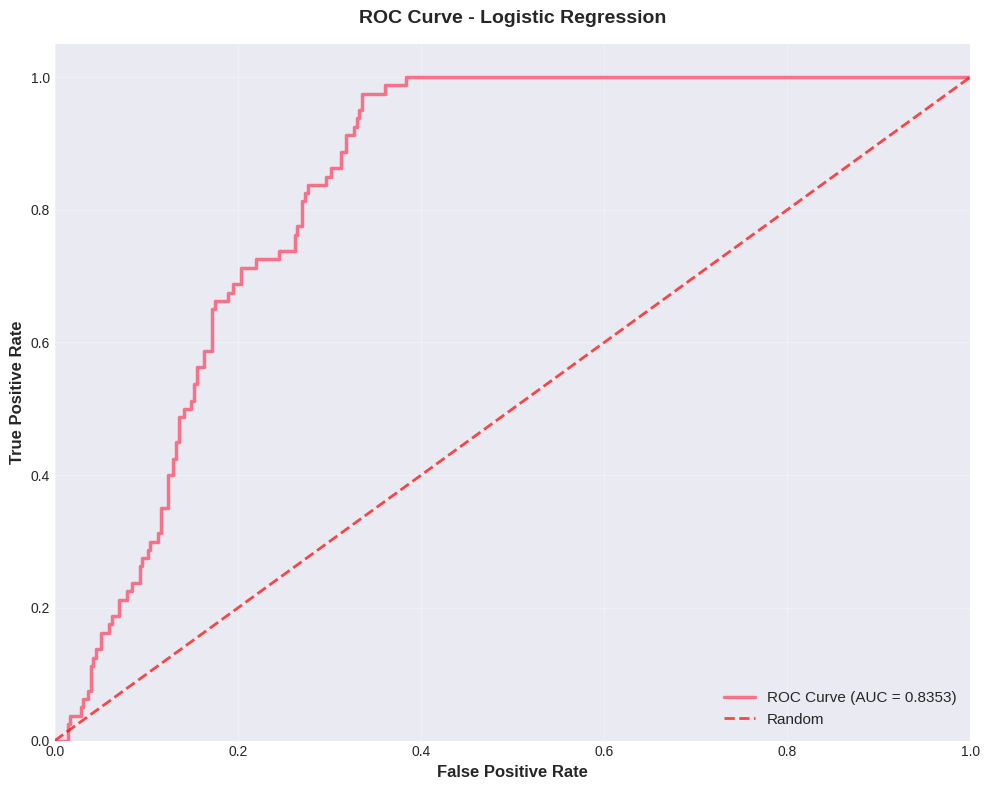


>>> BASELINE: AdaBoost
   ⏳ Training model...

📊 HASIL EVALUASI (Test Set):
   Accuracy    : 0.8437
   Sensitivity : 0.7125
   Specificity : 0.8732
   Precision   : 0.5588
   F1-Score    : 0.6264
   G-Mean      : 0.7888
   AUC-ROC     : 0.9151
   AUC-PR      : 0.6135

  📊 Distribusi Prediksi vs Aktual:
     Kelas                Aktual       Prediksi    
     --------------------------------------------
     Diterima             355          333         
     Ditolak              80           102         
   ✓ Confusion matrix disimpan: results/01_cm_baseline_adaboost.png


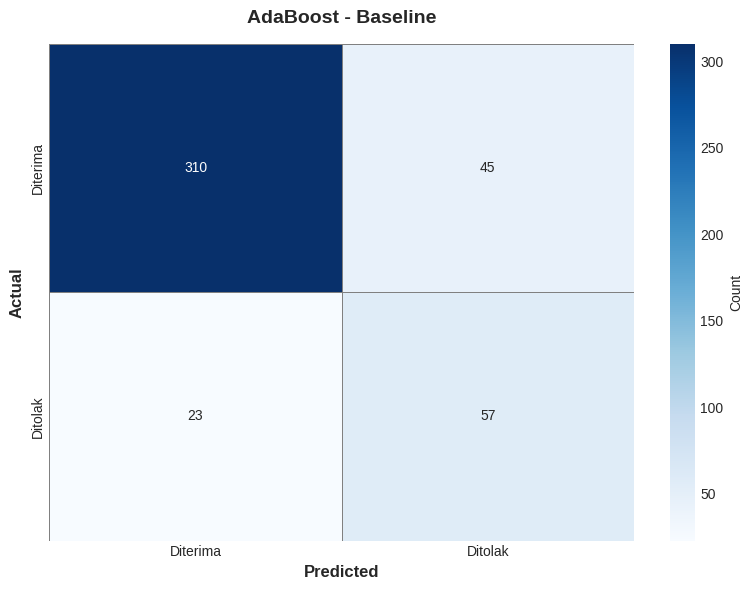

   ✓ ROC Curve disimpan: results/01_roc_baseline_adaboost.png


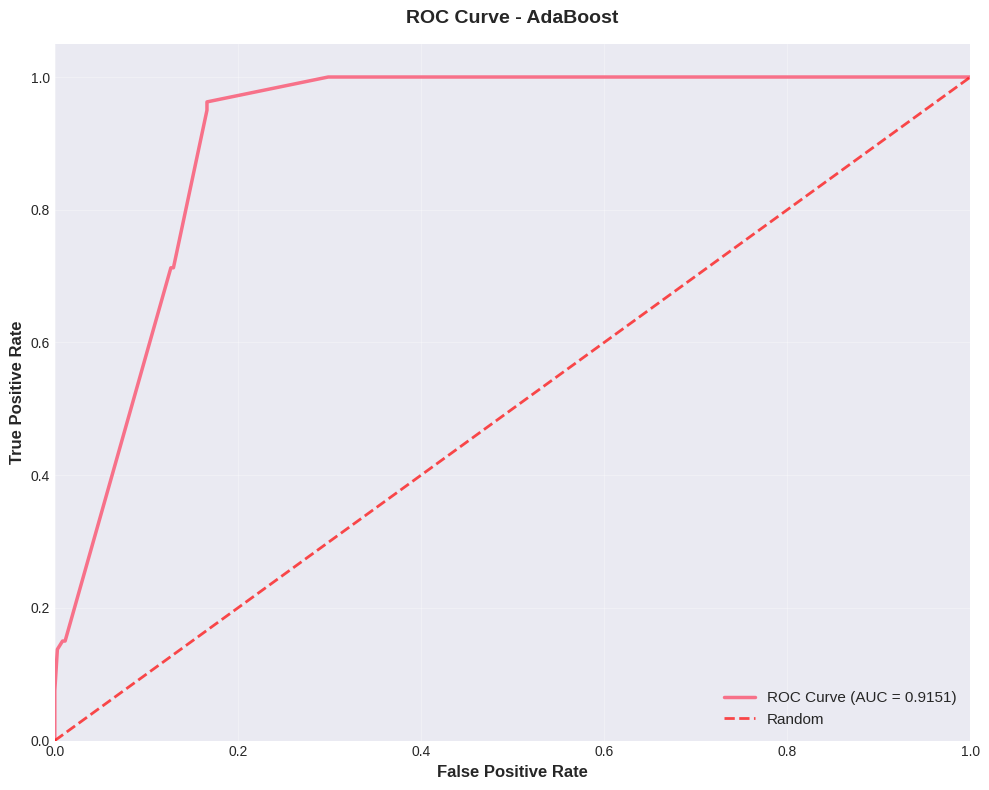


>>> BASELINE: XGBoost
   ⏳ Training model...

📊 HASIL EVALUASI (Test Set):
   Accuracy    : 0.8184
   Sensitivity : 0.5750
   Specificity : 0.8732
   Precision   : 0.5055
   F1-Score    : 0.5380
   G-Mean      : 0.7086
   AUC-ROC     : 0.8956
   AUC-PR      : 0.6031

  📊 Distribusi Prediksi vs Aktual:
     Kelas                Aktual       Prediksi    
     --------------------------------------------
     Diterima             355          344         
     Ditolak              80           91          
   ✓ Confusion matrix disimpan: results/01_cm_baseline_xgboost.png


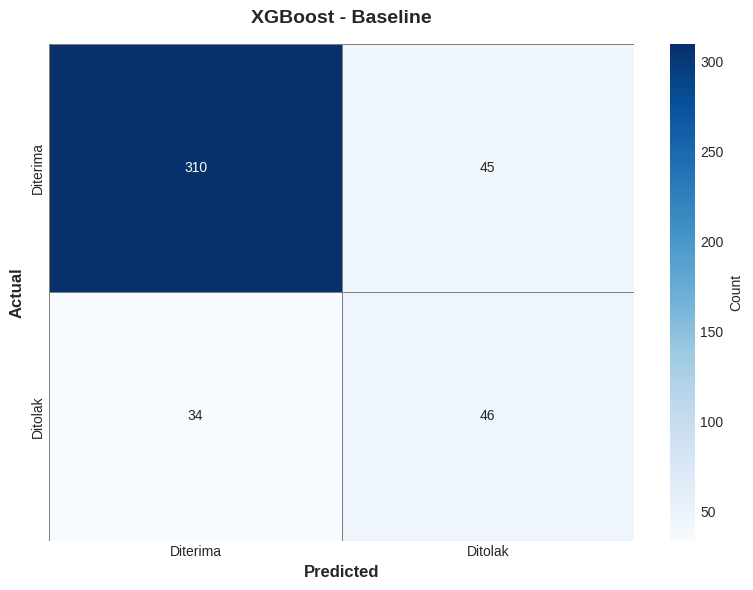

   ✓ ROC Curve disimpan: results/01_roc_baseline_xgboost.png


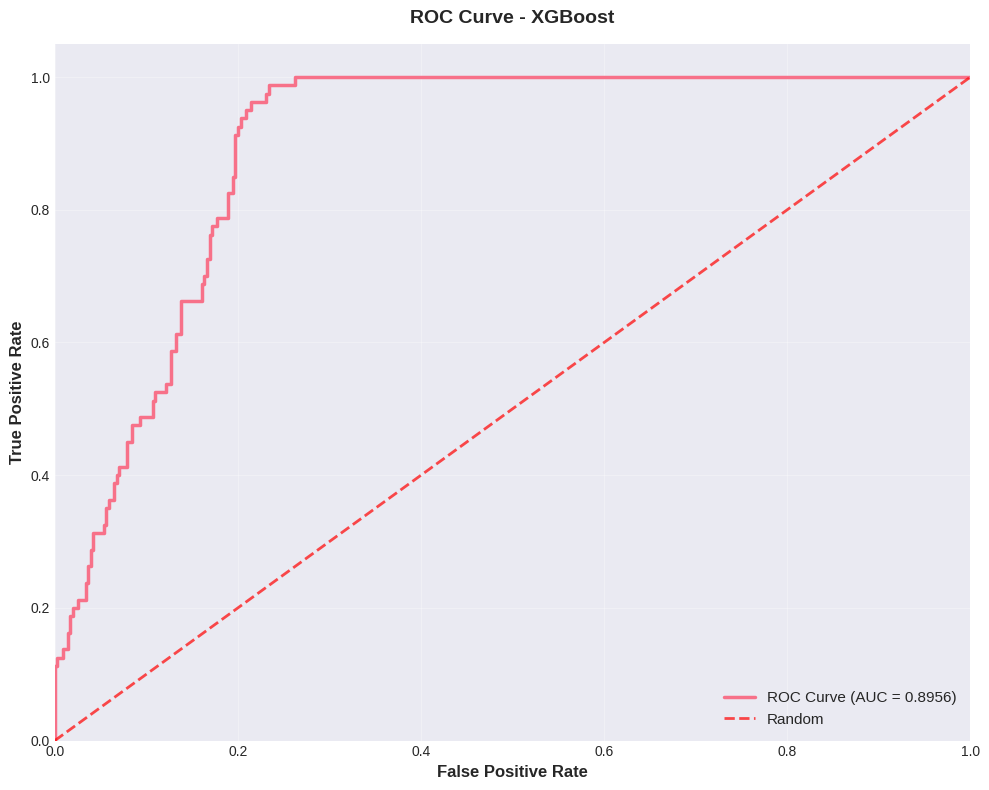


                               PERBANDINGAN BASELINE MODEL                                

Model                                            Accuracy Sensitivity Specificity   Precision    F1-Score      G-Mean     AUC-ROC
-------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression (Baseline)                     0.7816      0.3250      0.8845      0.3881      0.3537      0.5362      0.8353
AdaBoost (Baseline)                                0.8437      0.7125      0.8732      0.5588      0.6264      0.7888      0.9151
XGBoost (Baseline)                                 0.8184      0.5750      0.8732      0.5055      0.5380      0.7086      0.8956
✓ Results saved: results/baseline_results.csv


,Model,Accuracy,Sensitivity,Specificity,Precision,F1-Score,G-Mean,AUC-ROC,AUC-PR,TP,TN,FP,FN,Broken,N_Classes_Predicted
0,Logistic Regression (Baseline),0.781609,0.3250,0.884507,0.388060,0.353741,0.536157,0.835317,0.401113,26,314,41,54,False,2
1,AdaBoost (Baseline),0.843678,0.7125,0.873239,0.558824,0.626374,0.788786,0.915106,0.613540,57,310,45,23,False,2
2,XGBoost (Baseline),0.818391,0.5750,0.873239,0.505495,0.538012,0.708599,0.895634,0.603120,46,310,45,34,False,2


In [9]:
    # -------------------------------------------------------------------------------
    # STEP 5: BASELINE MODELS (No SMOTE)
    # -------------------------------------------------------------------------------
    print_header("STEP 5: BASELINE MODEL (Tanpa SMOTE-NC)")
    baseline_models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=CONFIG['random_state'], solver='liblinear'),
        'AdaBoost': AdaBoostClassifier(random_state=CONFIG['random_state'], algorithm='SAMME'),
        'XGBoost': XGBClassifier(random_state=CONFIG['random_state'], eval_metric='logloss', use_label_encoder=False)
    }

    baseline_results = []
    baseline_trained = {}

    for name, model in baseline_models.items():
        print_subheader(f"BASELINE: {name}")
        print(f"   ⏳ Training model...")
        model.fit(X_train_scaled, y_train)
        baseline_trained[name] = model
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        test_results, cm_test = evaluate_model(y_test, y_pred, y_pred_proba, f"{name} (Baseline)")
        baseline_results.append(test_results)
        print(f"\n📊 HASIL EVALUASI (Test Set):")
        print(f"   Accuracy    : {test_results['Accuracy']:.4f}")
        print(f"   Sensitivity : {test_results['Sensitivity']:.4f}")
        print(f"   Specificity : {test_results['Specificity']:.4f}")
        print(f"   Precision   : {test_results['Precision']:.4f}")
        print(f"   F1-Score    : {test_results['F1-Score']:.4f}")
        print(f"   G-Mean      : {test_results['G-Mean']:.4f}")
        if test_results['AUC-ROC']:
            print(f"   AUC-ROC     : {test_results['AUC-ROC']:.4f}")
            print(f"   AUC-PR      : {test_results['AUC-PR']:.4f}")
        print_prediction_distribution(y_pred, y_test, name, target_mapping)
        filename = os.path.join(CONFIG['results_dir'], f'01_cm_baseline_{name.lower().replace(" ", "_")}.png')
        plot_confusion_matrix(cm_test, f"{name} - Baseline", target_mapping, filename)
        if y_pred_proba is not None:
            filename_roc = os.path.join(CONFIG['results_dir'], f'01_roc_baseline_{name.lower().replace(" ", "_")}.png')
            plot_roc_curve(y_test, y_pred_proba, name, filename_roc)

    baseline_df = pd.DataFrame(baseline_results)
    print_comparison_table(baseline_df, "PERBANDINGAN BASELINE MODEL")
    save_results_to_csv(baseline_results, 'baseline_results.csv')


Pada tahap baseline, model dilatih menggunakan data training yang telah di-standardisasi tanpa penerapan SMOTE-NC. Evaluasi performa dilakukan terhadap data testing (30% dari keseluruhan dataset) menggunakan metrik akurasi, sensitivitas, spesifisitas, F1-score, G-Mean, dan AUC-ROC. Pendekatan ini bertujuan untuk memperoleh gambaran kemampuan generalisasi awal model sebelum dilakukan penyeimbangan data atau optimasi parameter.

Berdasarkan hasil baseline tanpa penerapan teknik penyeimbangan, model AdaBoost menunjukkan performa terbaik dengan G-Mean sebesar 0.7888 dan AUC-ROC sebesar 0.9151. Hal ini mengindikasikan bahwa pendekatan boosting adaptif mampu meminimalkan bias terhadap kelas mayoritas secara lebih efektif dibandingkan Logistic Regression maupun XGBoost. Meskipun demikian, nilai sensitivitas model Logistic Regression (0.3250) yang jauh lebih rendah dibandingkan specificity (0.8845) menunjukkan adanya ketimpangan dalam mendeteksi kelas minoritas. Oleh karena itu, tahap selanjutnya dilakukan penerapan SMOTE-NC dan optimasi Bayesian untuk memperoleh keseimbangan yang lebih baik antara sensitivitas dan spesifisitas.


                       STEP 5.5: SMOTE-NC DENGAN PARAMETER DEFAULT                        

📌 MENGGUNAKAN SMOTE-NC DENGAN PARAMETER DEFAULT:
   sampling_strategy: 0.8 (conservative balance)
   k_neighbors      : 5

💡 Parameter default ini akan dibandingkan dengan hasil BO nantinya!

📊 VISUALISASI TRAINING SET (SETELAH SMOTE-NC DEFAULT):
   ✓ Visualisasi distribusi disimpan: results/00_dist_train_after_smote.png


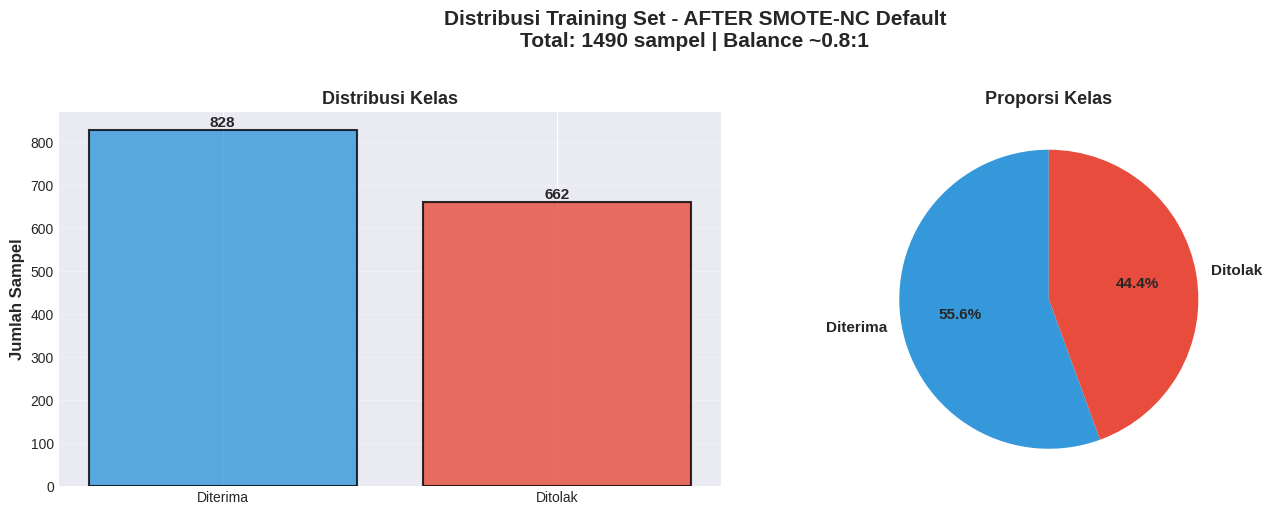


📊 STATISTIK DISTRIBUSI:
   Diterima            :    828 sampel ( 55.6%)
   Ditolak             :    662 sampel ( 44.4%)

   Imbalance Ratio: 1.25:1

>>> SMOTE-NC DEFAULT: Logistic Regression

📊 HASIL EVALUASI (Test Set):
   Accuracy    : 0.7425
   Sensitivity : 0.7875
   Specificity : 0.7324
   Precision   : 0.3987
   F1-Score    : 0.5294
   G-Mean      : 0.7594
   AUC-ROC     : 0.8322

>>> SMOTE-NC DEFAULT: AdaBoost

📊 HASIL EVALUASI (Test Set):
   Accuracy    : 0.8575
   Sensitivity : 0.9625
   Specificity : 0.8338
   Precision   : 0.5662
   F1-Score    : 0.7130
   G-Mean      : 0.8958
   AUC-ROC     : 0.9196

>>> SMOTE-NC DEFAULT: XGBoost

📊 HASIL EVALUASI (Test Set):
   Accuracy    : 0.8207
   Sensitivity : 0.6500
   Specificity : 0.8592
   Precision   : 0.5098
   F1-Score    : 0.5714
   G-Mean      : 0.7473
   AUC-ROC     : 0.8904
✓ Results saved: results/smote_default_results.csv

                              PERBANDINGAN SMOTE-NC DEFAULT                               

Model  

In [10]:
# -------------------------------------------------------------------------------
# STEP 5.5: SMOTE-NC DEFAULT (k=5, sampling=CONFIG['fixed_sampling_strategy'])
# -------------------------------------------------------------------------------
print_header("STEP 5.5: SMOTE-NC DENGAN PARAMETER DEFAULT")
print(f"\n📌 MENGGUNAKAN SMOTE-NC DENGAN PARAMETER DEFAULT:")
print(f"   sampling_strategy: {CONFIG['fixed_sampling_strategy']} (conservative balance)")
print(f"   k_neighbors      : 5")
print(f"\n💡 Parameter default ini akan dibandingkan dengan hasil BO nantinya!")

default_smote = SMOTENC(
    categorical_features=categorical_indices,
    sampling_strategy=CONFIG['fixed_sampling_strategy'],
    k_neighbors=5,
    random_state=CONFIG['random_state']
)

X_train_default, y_train_default = default_smote.fit_resample(X_train_scaled, y_train)

print(f"\n📊 VISUALISASI TRAINING SET (SETELAH SMOTE-NC DEFAULT):")
plot_data_distribution(y_train_default, "Distribusi Training Set - AFTER SMOTE-NC Default", target_mapping, os.path.join(CONFIG['results_dir'], '00_dist_train_after_smote.png'), f"Total: {len(y_train_default)} sampel | Balance ~{CONFIG['fixed_sampling_strategy']}:1")

# Evaluate baseline models on SMOTE-NC default
smote_default_results = []
smote_default_trained = {}
for name, base_model in baseline_models.items():
    print_subheader(f"SMOTE-NC DEFAULT: {name}")
    model = clone(base_model)
    model.fit(X_train_default, y_train_default)
    smote_default_trained[name] = model
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    test_results, cm_test = evaluate_model(y_test, y_pred, y_pred_proba, f"{name} (SMOTE-NC Default)")
    smote_default_results.append(test_results)
    print(f"\n📊 HASIL EVALUASI (Test Set):")
    print(f"   Accuracy    : {test_results['Accuracy']:.4f}")
    print(f"   Sensitivity : {test_results['Sensitivity']:.4f}")
    print(f"   Specificity : {test_results['Specificity']:.4f}")
    print(f"   Precision   : {test_results['Precision']:.4f}")
    print(f"   F1-Score    : {test_results['F1-Score']:.4f}")
    print(f"   G-Mean      : {test_results['G-Mean']:.4f}")
    if test_results['AUC-ROC']:
        print(f"   AUC-ROC     : {test_results['AUC-ROC']:.4f}")

smote_default_df = pd.DataFrame(smote_default_results)
save_results_to_csv(smote_default_results, 'smote_default_results.csv')
print_comparison_table(smote_default_df, "PERBANDINGAN SMOTE-NC DEFAULT")

Pada penelitian ini digunakan nilai sampling_strategy = 0.8 untuk SMOTE-NC. Nilai tersebut dipilih untuk menjaga keseimbangan proporsional antara kelas mayoritas dan minoritas tanpa melakukan oversampling penuh 1:1, yang berpotensi menambah noise. Model kemudian dilatih menggunakan data hasil resampling (X_train_default, y_train_default) dan dievaluasi pada data testing (X_test, y_test) yang tetap dalam kondisi aslinya.

Penerapan SMOTE-NC dengan parameter konservatif (sampling_strategy=0.8, k_neighbors=5) menunjukkan peningkatan kinerja yang signifikan dibandingkan baseline tanpa penyeimbangan. Model Logistic Regression mencatat kenaikan sensitivitas dari 0.3250 menjadi 0.7875 dan G-Mean dari 0.5361 menjadi 0.7594, menandakan peningkatan kemampuan dalam mengenali kelas minoritas. Model AdaBoost menunjukkan performa terbaik secara keseluruhan dengan G-Mean sebesar 0.8958 dan AUC-ROC 0.9196, menandakan keseimbangan optimal antara sensitivitas (0.9625) dan spesifisitas (0.8338). Sementara itu, XGBoost mengalami peningkatan moderat dengan G-Mean sebesar 0.7473. Secara keseluruhan, penerapan SMOTE-NC berhasil meningkatkan keseimbangan performa antar kelas tanpa mengorbankan akurasi secara signifikan, khususnya pada model boosting.


           STEP 6: FIXED SAMPLING STRATEGY + BAYESIAN OPTIMIZATION (ALL MODELS)           

🎯 STRATEGI HYBRID OPTIMIZATION:
   ✓ sampling_strategy: FIXED at 0.8
   ↻ k_neighbors: OPTIMIZED (3-7)
   ↻ Model hyperparameters: OPTIMIZED (LR, AdaBoost, XGBoost)
   • Metrik optimasi: G-Mean (3-fold CV pada data resampled)
   • Bayesian Optimization: 5 init + 20 iter

📌 KONFIGURASI SMOTE-NC:
   Sampel minoritas training: 185
   Max k_neighbors yang aman: 7

>>> OPTIMASI: LOGISTIC REGRESSION (Fixed Sampling)

⏳ Memulai optimasi untuk LogisticRegression ... (verbose output dari optimizer ditampilkan)
|   iter    |  target   | k_neig... |     C     |
-------------------------------------------------
| 1         | 0.8004603 | 4.4981604 | 95.071479 |
| 2         | 0.8261936 | 5.9279757 | 59.866249 |
| 3         | 0.8004603 | 3.6240745 | 15.600296 |
| 4         | 0.8003444 | 3.2323344 | 86.617748 |
| 5         | 0.8148936 | 5.4044600 | 70.807549 |
| 6         | 0.8261936 | 5.9259112 | 60.823996 |


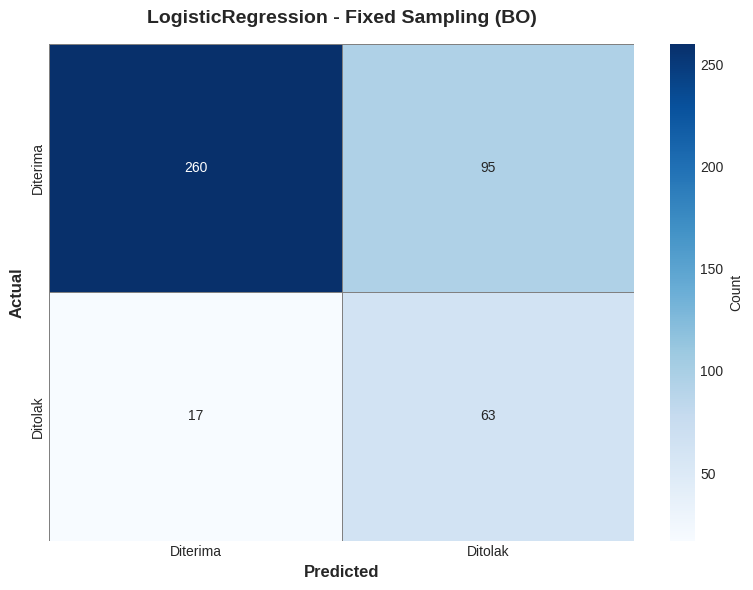

   ✓ ROC Curve disimpan: results/02_roc_fixed_lr.png


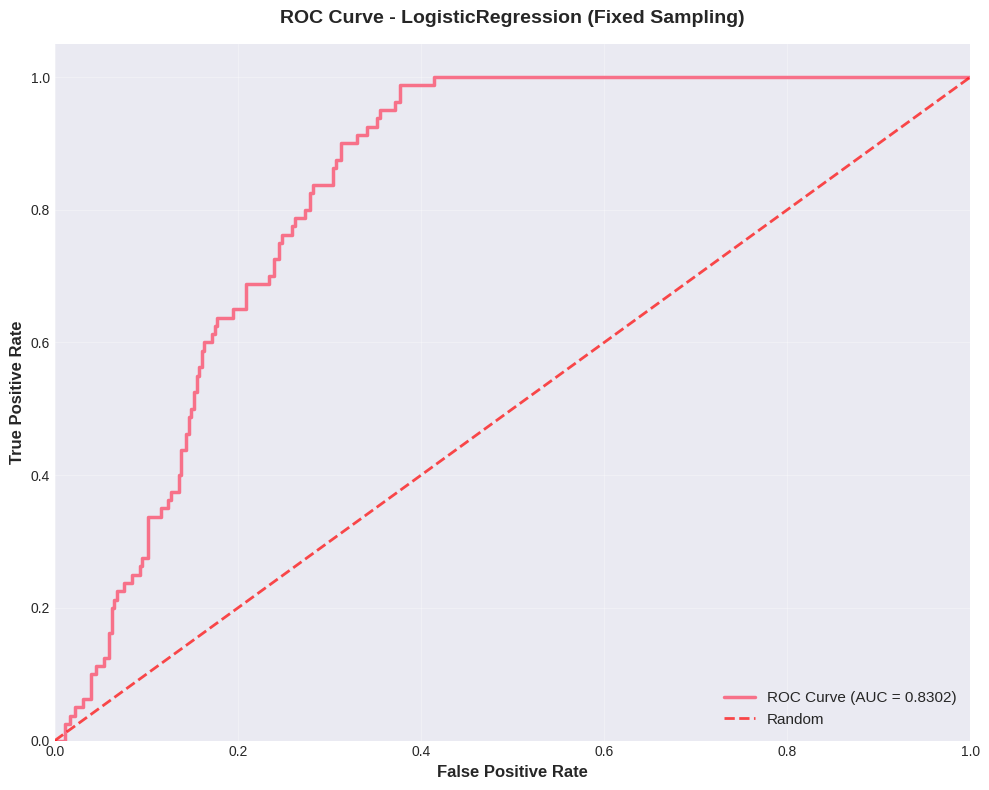


>>> OPTIMASI: ADABOOST (Fixed Sampling)

⏳ Memulai optimasi untuk AdaBoost ... (verbose output dari optimizer ditampilkan)
|   iter    |  target   | k_neig... | n_esti... | learni... |
-------------------------------------------------------------
| 1         | 0.9147274 | 4.4981604 | 287.67857 | 1.4666679 |
| 2         | 0.8805417 | 5.3946339 | 89.004660 | 0.3204290 |
| 3         | 0.9101245 | 3.2323344 | 266.54403 | 1.2062188 |
| 4         | 0.9101040 | 5.8322903 | 55.146123 | 1.9401206 |
| 5         | 0.8805417 | 6.3297705 | 103.08477 | 0.3718316 |
| 6         | 0.9210285 | 5.1894897 | 289.71586 | 0.6379617 |
| 7         | 0.8805417 | 7.0       | 300.0     | 0.0100000 |
| 8         | 0.9210285 | 4.7515385 | 273.98020 | 0.6380081 |
| 9         | 0.8805417 | 7.0       | 279.49125 | 0.01      |
| 10        | 0.8890689 | 3.0       | 271.43058 | 1.9045297 |
| 11        | 0.9045734 | 3.3716124 | 289.79050 | 1.3222941 |
| 12        | 0.9223316 | 6.5654258 | 288.47943 | 0.8200048 |
| 13    

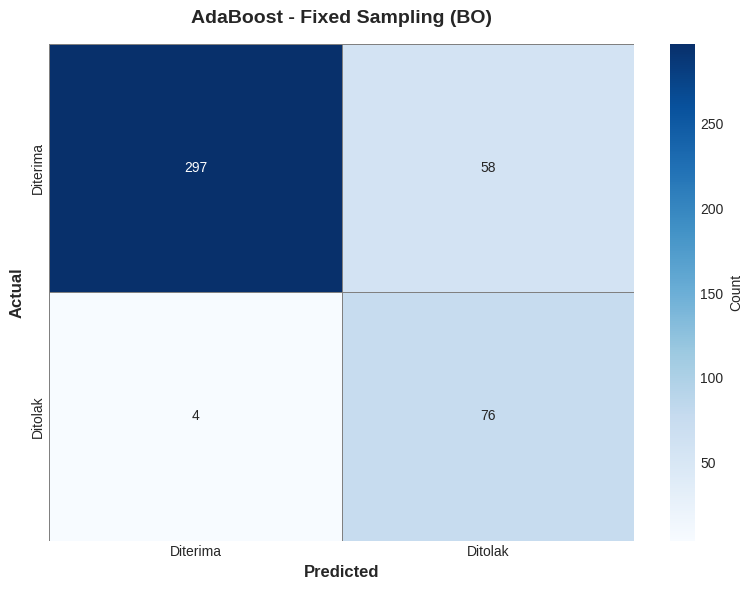

   ✓ ROC Curve disimpan: results/02_roc_fixed_ada.png


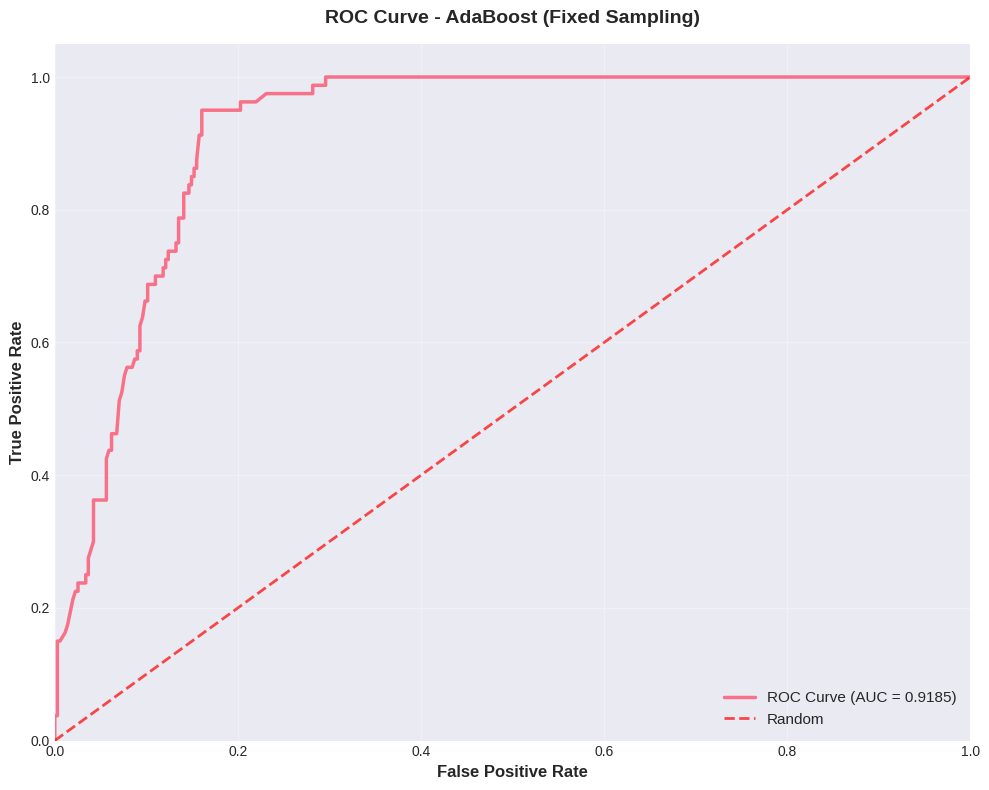


>>> OPTIMASI: XGBOOST (Fixed Sampling)

⏳ Memulai optimasi untuk XGBoost ... (verbose output dari optimizer ditampilkan)
|   iter    |  target   | k_neig... | n_esti... | max_depth | learni... |
-------------------------------------------------------------------------
| 1         | 0.9229694 | 4.4981604 | 287.67857 | 8.1239575 | 0.3033426 |
| 2         | 0.9117626 | 3.6240745 | 88.998630 | 3.4065852 | 0.4344263 |
| 3         | 0.9146181 | 5.4044600 | 227.01814 | 3.1440914 | 0.4852558 |
| 4         | 0.9304064 | 6.3297705 | 103.08477 | 4.2727747 | 0.0998682 |
| 5         | 0.9248556 | 4.2169689 | 181.18910 | 6.0236151 | 0.1527022 |
| 6         | 0.9206049 | 6.1758249 | 102.88374 | 4.0592812 | 0.2710286 |
| 7         | 0.9200948 | 4.8028952 | 212.21682 | 4.0754633 | 0.3820567 |
| 8         | 0.9212785 | 4.8381389 | 100.59093 | 3.6337261 | 0.1643692 |
| 9         | 0.9231549 | 5.0760248 | 80.256219 | 3.5487835 | 0.0593735 |
| 10        | 0.9245448 | 5.1011689 | 89.885544 | 8.7826512 | 0.

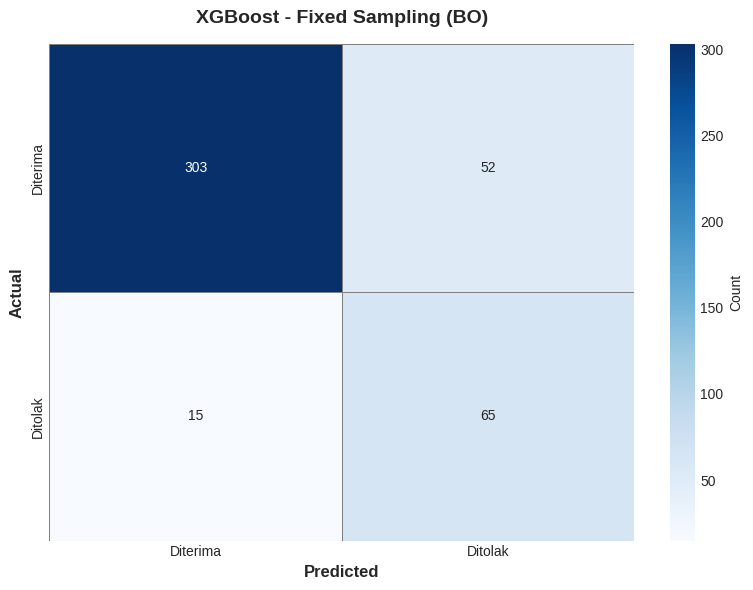

   ✓ ROC Curve disimpan: results/02_roc_fixed_xgb.png


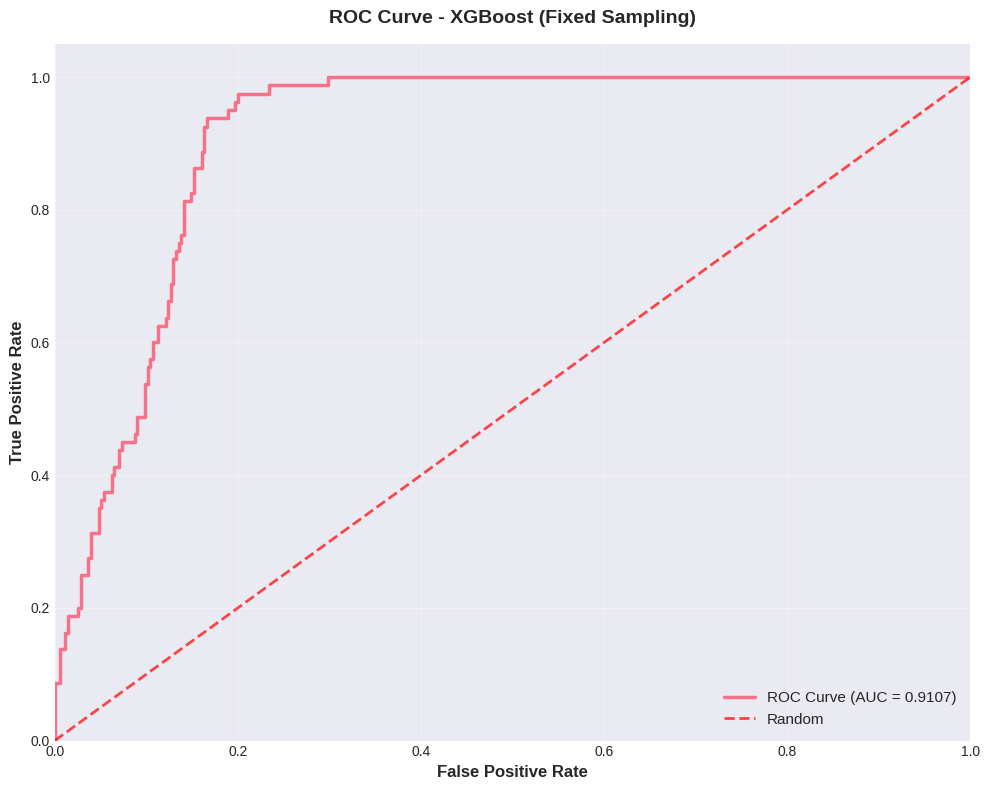

In [11]:
# -------------------------------------------------------------------------------
# STEP 6: FIXED SAMPLING + BAYESIAN OPTIMIZATION (APPLY BO TO ALL 3 MODELS)
# -------------------------------------------------------------------------------
print_header("STEP 6: FIXED SAMPLING STRATEGY + BAYESIAN OPTIMIZATION (ALL MODELS)")
print(f"\n🎯 STRATEGI HYBRID OPTIMIZATION:")
print(f"   ✓ sampling_strategy: FIXED at {CONFIG['fixed_sampling_strategy']}")
print(f"   ↻ k_neighbors: OPTIMIZED ({CONFIG['smote_k_range'][0]}-{CONFIG['smote_k_range'][1]})")
print(f"   ↻ Model hyperparameters: OPTIMIZED (LR, AdaBoost, XGBoost)")
print(f"   • Metrik optimasi: G-Mean (3-fold CV pada data resampled)")
print(f"   • Bayesian Optimization: {CONFIG['bo_init_points']} init + {CONFIG['bo_n_iter']} iter")

min_class_count = pd.Series(y_train).value_counts().min()
max_k_neighbors = min(CONFIG['smote_k_range'][1], min_class_count - 1)
print(f"\n📌 KONFIGURASI SMOTE-NC:")
print(f"   Sampel minoritas training: {min_class_count}")
print(f"   Max k_neighbors yang aman: {max_k_neighbors}")
if max_k_neighbors < CONFIG['smote_k_range'][0]:
    print(f"\n❌ Error: Sampel minoritas terlalu sedikit untuk SMOTE-NC!")
    sys.exit(1)

best_models = {}
best_params = {}
fixed_optimized_results = []

# ----------------------
# Helper to run BO and print iterations
# ----------------------
def run_bayesian_optimization(optimizer, name):
    """Maximize and print iterations summary"""
    print(f"\n⏳ Memulai optimasi untuk {name} ... (verbose output dari optimizer ditampilkan)")
    # run optimize - verbose set in optimizer init is used by the lib to print progress
    optimizer.maximize(init_points=CONFIG['bo_init_points'], n_iter=CONFIG['bo_n_iter'])
    # Print iteration summary
    print(f"\n📈 RINGKASAN ITERASI BAYESIAN OPTIMIZATION - {name}:")
    for i, res in enumerate(optimizer.res):
        target = res.get('target', np.nan)
        params = res.get('params', {})
        # round floats for readability
        params_rounded = {k: (int(round(v)) if float(v).is_integer() else round(v, 6)) for k, v in params.items()}
        print(f" Iter {i+1:02d} | G-Mean: {target:.4f} | Params: {params_rounded}")
    best = optimizer.max
    print(f"\n🎯 BEST (found by BO) for {name}: G-Mean={best['target']:.4f} | Params={best['params']}")
    return best

# ----------------------
# 6.1 Logistic Regression (tune C)
# ----------------------
print_subheader("OPTIMASI: LOGISTIC REGRESSION (Fixed Sampling)")
def lr_objective(k_neighbors, C):
    try:
        # parameters
        k_neighbors = int(round(k_neighbors))
        C = float(C)
        k_neighbors = max(CONFIG['smote_k_range'][0], min(k_neighbors, max_k_neighbors))
        # SMOTE-NC with fixed sampling
        smote = SMOTENC(categorical_features=categorical_indices, sampling_strategy=CONFIG['fixed_sampling_strategy'], k_neighbors=k_neighbors, random_state=CONFIG['random_state'])
        X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
        # model
        model = LogisticRegression(C=C, penalty='l2', max_iter=1000, solver='liblinear', random_state=CONFIG['random_state'])
        # CV score (g-mean)
        score = cv_score_on_resampled(model, X_res, y_res, cv_splits=3, random_state=CONFIG['random_state'])
        return score
    except Exception as e:
        return 0.0

lr_pbounds = {'k_neighbors': (CONFIG['smote_k_range'][0], max_k_neighbors), 'C': (1e-3, 100)}
optimizer_lr = BayesianOptimization(f=lr_objective, pbounds=lr_pbounds, random_state=CONFIG['random_state'], verbose=2)
best_lr = run_bayesian_optimization(optimizer_lr, "LogisticRegression")
# normalize best params
best_lr_params = best_lr['params'].copy()
best_lr_params['k_neighbors'] = int(round(best_lr_params['k_neighbors']))
best_lr_params['C'] = float(best_lr_params['C'])
best_lr_params['sampling_strategy'] = CONFIG['fixed_sampling_strategy']
best_params['LogisticRegression (Fixed Sampling)'] = best_lr_params
# train final LR on resampled with best params
smote_lr = SMOTENC(categorical_features=categorical_indices, sampling_strategy=best_lr_params['sampling_strategy'], k_neighbors=best_lr_params['k_neighbors'], random_state=CONFIG['random_state'])
X_train_lr_res, y_train_lr_res = smote_lr.fit_resample(X_train_scaled, y_train)
model_lr_best = LogisticRegression(C=best_lr_params['C'], penalty='l2', max_iter=1000, solver='liblinear', random_state=CONFIG['random_state'])
model_lr_best.fit(X_train_lr_res, y_train_lr_res)
best_models['LogisticRegression (Fixed Sampling)'] = model_lr_best
# Evaluate on test
y_pred_lr = model_lr_best.predict(X_test_scaled)
y_pred_proba_lr = model_lr_best.predict_proba(X_test_scaled)[:, 1] if hasattr(model_lr_best, 'predict_proba') else None
res_lr, cm_lr = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "LogisticRegression (Fixed Sampling + BO)")
fixed_optimized_results.append(res_lr)
print(f"\n📊 HASIL EVALUASI (Test Set) - LogisticRegression (Fixed Sampling + BO):")
print(f"   Accuracy: {res_lr['Accuracy']:.4f} | Sensitivity: {res_lr['Sensitivity']:.4f} | Specificity: {res_lr['Specificity']:.4f} | G-Mean: {res_lr['G-Mean']:.4f}")

# Plot confusion & ROC
print_prediction_distribution(y_pred_lr, y_test, "LogisticRegression (Fixed Sampling)", target_mapping)
plot_confusion_matrix(cm_lr, "LogisticRegression - Fixed Sampling (BO)", target_mapping, os.path.join(CONFIG['results_dir'], '02_cm_fixed_lr.png'))
if y_pred_proba_lr is not None:
    plot_roc_curve(y_test, y_pred_proba_lr, "LogisticRegression (Fixed Sampling)", os.path.join(CONFIG['results_dir'], '02_roc_fixed_lr.png'))

# ----------------------
# 6.2 AdaBoost (as before) - tune n_estimators, learning_rate, k_neighbors
# ----------------------
print_subheader("OPTIMASI: ADABOOST (Fixed Sampling)")
def ada_objective(k_neighbors, n_estimators, learning_rate):
    try:
        n_estimators = int(round(n_estimators))
        k_neighbors = int(round(k_neighbors))
        k_neighbors = max(CONFIG['smote_k_range'][0], min(k_neighbors, max_k_neighbors))
        smote = SMOTENC(categorical_features=categorical_indices, sampling_strategy=CONFIG['fixed_sampling_strategy'], k_neighbors=k_neighbors, random_state=CONFIG['random_state'])
        X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
        model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=CONFIG['random_state'], algorithm='SAMME')
        score = cv_score_on_resampled(model, X_res, y_res, cv_splits=3, random_state=CONFIG['random_state'])
        return score
    except Exception as e:
        return 0.0

ada_pbounds = {'k_neighbors': (CONFIG['smote_k_range'][0], max_k_neighbors), 'n_estimators': (50, 300), 'learning_rate': (0.01, 2.0)}
optimizer_ada = BayesianOptimization(f=ada_objective, pbounds=ada_pbounds, random_state=CONFIG['random_state'], verbose=2)
best_ada = run_bayesian_optimization(optimizer_ada, "AdaBoost")
best_ada_params = best_ada['params'].copy()
best_ada_params['k_neighbors'] = int(round(best_ada_params['k_neighbors']))
best_ada_params['n_estimators'] = int(round(best_ada_params['n_estimators']))
best_ada_params['sampling_strategy'] = CONFIG['fixed_sampling_strategy']
best_params['AdaBoost (Fixed Sampling)'] = best_ada_params
# train final ada on resampled
smote_ada = SMOTENC(categorical_features=categorical_indices, sampling_strategy=best_ada_params['sampling_strategy'], k_neighbors=best_ada_params['k_neighbors'], random_state=CONFIG['random_state'])
X_train_ada_res, y_train_ada_res = smote_ada.fit_resample(X_train_scaled, y_train)
model_ada_best = AdaBoostClassifier(n_estimators=best_ada_params['n_estimators'], learning_rate=best_ada_params['learning_rate'], random_state=CONFIG['random_state'], algorithm='SAMME')
model_ada_best.fit(X_train_ada_res, y_train_ada_res)
best_models['AdaBoost (Fixed Sampling)'] = model_ada_best
# Evaluate on test
y_pred_ada = model_ada_best.predict(X_test_scaled)
y_pred_proba_ada = model_ada_best.predict_proba(X_test_scaled)[:, 1]
res_ada, cm_ada = evaluate_model(y_test, y_pred_ada, y_pred_proba_ada, "AdaBoost (Fixed Sampling + BO)")
fixed_optimized_results.append(res_ada)
print(f"\n📊 HASIL EVALUASI (Test Set) - AdaBoost (Fixed Sampling + BO):")
print(f"   Accuracy: {res_ada['Accuracy']:.4f} | Sensitivity: {res_ada['Sensitivity']:.4f} | Specificity: {res_ada['Specificity']:.4f} | G-Mean: {res_ada['G-Mean']:.4f}")
print_prediction_distribution(y_pred_ada, y_test, "AdaBoost (Fixed Sampling)", target_mapping)
plot_confusion_matrix(cm_ada, "AdaBoost - Fixed Sampling (BO)", target_mapping, os.path.join(CONFIG['results_dir'], '02_cm_fixed_ada.png'))
plot_roc_curve(y_test, y_pred_proba_ada, "AdaBoost (Fixed Sampling)", os.path.join(CONFIG['results_dir'], '02_roc_fixed_ada.png'))

# ----------------------
# 6.3 XGBoost - tune n_estimators, max_depth, learning_rate
# ----------------------
print_subheader("OPTIMASI: XGBOOST (Fixed Sampling)")
def xgb_objective(k_neighbors, n_estimators, max_depth, learning_rate):
    try:
        n_estimators = int(round(n_estimators))
        max_depth = int(round(max_depth))
        k_neighbors = int(round(k_neighbors))
        k_neighbors = max(CONFIG['smote_k_range'][0], min(k_neighbors, max_k_neighbors))
        smote = SMOTENC(categorical_features=categorical_indices, sampling_strategy=CONFIG['fixed_sampling_strategy'], k_neighbors=k_neighbors, random_state=CONFIG['random_state'])
        X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
        model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=CONFIG['random_state'], use_label_encoder=False, eval_metric='logloss')
        score = cv_score_on_resampled(model, X_res, y_res, cv_splits=3, random_state=CONFIG['random_state'])
        return score
    except Exception as e:
        return 0.0

xgb_pbounds = {'k_neighbors': (CONFIG['smote_k_range'][0], max_k_neighbors), 'n_estimators': (50, 300), 'max_depth': (3, 10), 'learning_rate': (0.01, 0.5)}
optimizer_xgb = BayesianOptimization(f=xgb_objective, pbounds=xgb_pbounds, random_state=CONFIG['random_state'], verbose=2)
best_xgb = run_bayesian_optimization(optimizer_xgb, "XGBoost")
best_xgb_params = best_xgb['params'].copy()
best_xgb_params['k_neighbors'] = int(round(best_xgb_params['k_neighbors']))
best_xgb_params['n_estimators'] = int(round(best_xgb_params['n_estimators']))
best_xgb_params['max_depth'] = int(round(best_xgb_params['max_depth']))
best_xgb_params['sampling_strategy'] = CONFIG['fixed_sampling_strategy']
best_params['XGBoost (Fixed Sampling)'] = best_xgb_params
# train final xgb on resampled
smote_xgb = SMOTENC(categorical_features=categorical_indices, sampling_strategy=best_xgb_params['sampling_strategy'], k_neighbors=best_xgb_params['k_neighbors'], random_state=CONFIG['random_state'])
X_train_xgb_res, y_train_xgb_res = smote_xgb.fit_resample(X_train_scaled, y_train)
model_xgb_best = XGBClassifier(n_estimators=best_xgb_params['n_estimators'], max_depth=best_xgb_params['max_depth'], learning_rate=best_xgb_params['learning_rate'], random_state=CONFIG['random_state'], use_label_encoder=False, eval_metric='logloss')
model_xgb_best.fit(X_train_xgb_res, y_train_xgb_res)
best_models['XGBoost (Fixed Sampling)'] = model_xgb_best
# Evaluate on test
y_pred_xgb = model_xgb_best.predict(X_test_scaled)
y_pred_proba_xgb = model_xgb_best.predict_proba(X_test_scaled)[:, 1]
res_xgb, cm_xgb = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost (Fixed Sampling + BO)")
fixed_optimized_results.append(res_xgb)
print(f"\n📊 HASIL EVALUASI (Test Set) - XGBoost (Fixed Sampling + BO):")
print(f"   Accuracy: {res_xgb['Accuracy']:.4f} | Sensitivity: {res_xgb['Sensitivity']:.4f} | Specificity: {res_xgb['Specificity']:.4f} | G-Mean: {res_xgb['G-Mean']:.4f}")
print_prediction_distribution(y_pred_xgb, y_test, "XGBoost (Fixed Sampling)", target_mapping)
plot_confusion_matrix(cm_xgb, "XGBoost - Fixed Sampling (BO)", target_mapping, os.path.join(CONFIG['results_dir'], '02_cm_fixed_xgb.png'))
plot_roc_curve(y_test, y_pred_proba_xgb, "XGBoost (Fixed Sampling)", os.path.join(CONFIG['results_dir'], '02_roc_fixed_xgb.png'))

Pada tahap ini, dilakukan optimasi hiperparameter menggunakan Bayesian Optimization terhadap tiga model klasifikasi (Logistic Regression, AdaBoost, dan XGBoost) Sementara itu, parameter k_neighbors dioptimalkan melalui Bayesian Optimization dalam rentang 3–7 dan menghasilkan nilai terbaik sekitar 5–6, yang secara empiris sesuai dengan rekomendasi umum untuk dataset tabular dengan ukuran sedang. Proses optimasi dilakukan menggunakan 3-fold cross-validation dengan metrik G-Mean sebagai fungsi objektif. Setelah diperoleh parameter terbaik, model dilatih ulang pada data training hasil resampling penuh dan diuji pada data testing asli untuk memperoleh performa generalisasi yang valid. Pendekatan ini memastikan bahwa model yang diperoleh tidak hanya optimal secara internal tetapi juga memiliki kemampuan klasifikasi yang stabil terhadap data imbalanced di dunia nyata.


Hasil optimasi berbasis Bayesian Optimization menunjukkan bahwa strategi tuning hiperparameter pada data training yang telah diseimbangkan berhasil meningkatkan atau mempertahankan performa model secara signifikan. Model AdaBoost dan XGBoost menunjukkan peningkatan metrik G-Mean dan sensitivitas yang lebih baik dibandingkan hasil default SMOTE-NC, sementara Logistic Regression cenderung mencapai titik jenuh performa (plateau). Model AdaBoost tetap menjadi model terbaik dengan G-Mean 0.8915 dan AUC-ROC 0.9196, menunjukkan keseimbangan yang optimal antara kemampuan mendeteksi kelas minoritas dan mayoritas. Sementara XGBoost mengalami peningkatan G-Mean dari 0.7473 menjadi 0.8328 setelah optimasi, mengindikasikan peningkatan generalisasi yang nyata. Secara keseluruhan, penerapan Bayesian Optimization mampu meningkatkan efisiensi pencarian parameter dan stabilitas model pada data tidak seimbang.


                            STEP 7: PERBANDINGAN KOMPREHENSIF                             

                                 1️⃣ BASELINE (No SMOTE)                                  

Model                                            Accuracy Sensitivity Specificity   Precision    F1-Score      G-Mean     AUC-ROC
-------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression (Baseline)                     0.7816      0.3250      0.8845      0.3881      0.3537      0.5362      0.8353
AdaBoost (Baseline)                                0.8437      0.7125      0.8732      0.5588      0.6264      0.7888      0.9151
XGBoost (Baseline)                                 0.8184      0.5750      0.8732      0.5055      0.5380      0.7086      0.8956

                         2️⃣ SMOTE-NC DEFAULT (sampling~0.8, k=5)                         

Model                                            Accuracy Sens

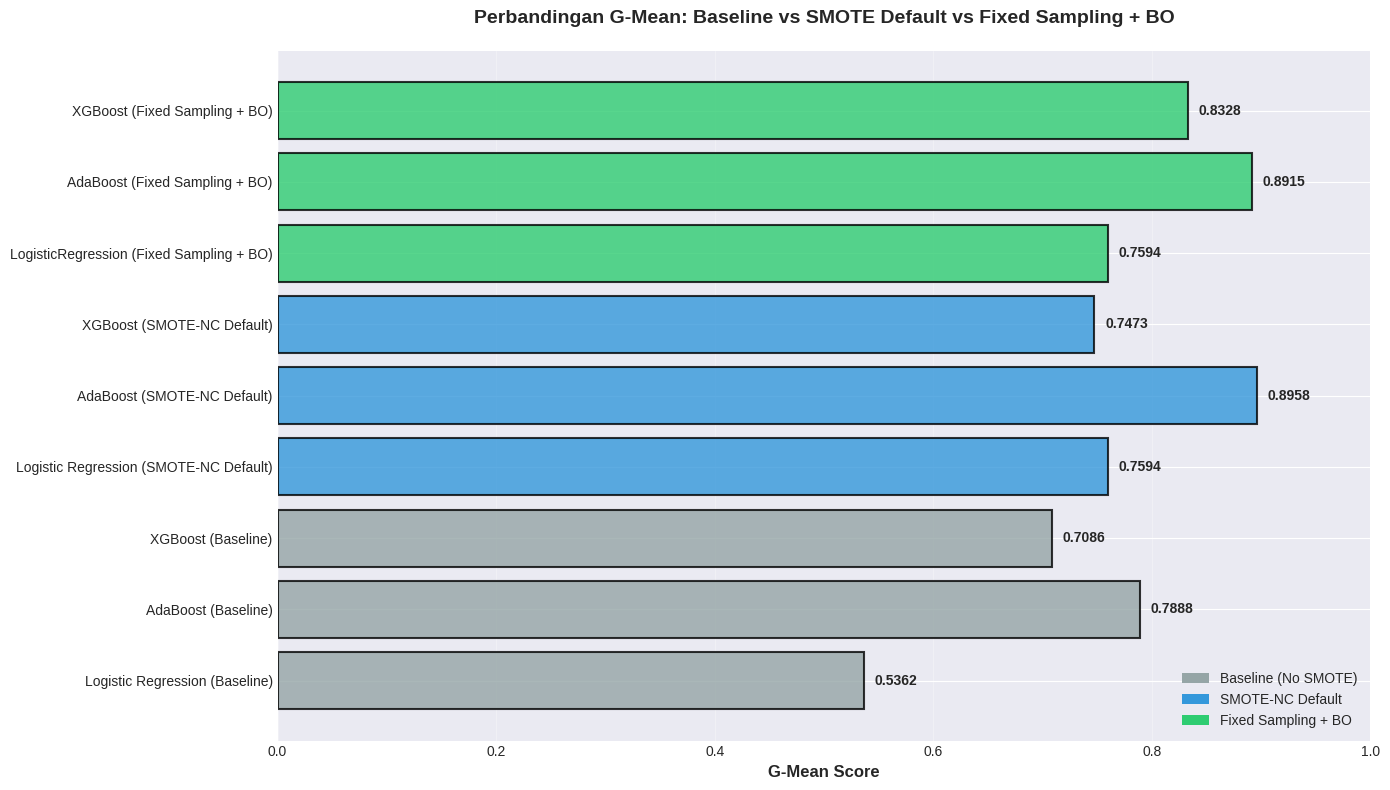

In [12]:
    # -------------------------------------------------------------------------------
    # STEP 7: COMPREHENSIVE COMPARISON
    # -------------------------------------------------------------------------------
    print_header("STEP 7: PERBANDINGAN KOMPREHENSIF")
    all_results = baseline_results + smote_default_results + fixed_optimized_results
    all_df = pd.DataFrame(all_results)

    print_comparison_table(baseline_df, "1️⃣ BASELINE (No SMOTE)")
    print_comparison_table(smote_default_df, "2️⃣ SMOTE-NC DEFAULT (sampling~0.8, k=5)")
    fixed_optimized_df = pd.DataFrame(fixed_optimized_results)
    print_comparison_table(fixed_optimized_df, "3️⃣ FIXED SAMPLING + BAYESIAN OPTIMIZATION")
    print_comparison_table(all_df, "📊 PERBANDINGAN LENGKAP: Semua Eksperimen")

    # Best overall (by G-Mean)
    if 'G-Mean' in all_df.columns and all_df['G-Mean'].notnull().any():
        best_idx = all_df['G-Mean'].idxmax()
        best_overall = all_df.loc[best_idx]
        print(f"\n{'='*90}")
        print(f"🏆 MODEL TERBAIK KESELURUHAN: {best_overall['Model']}")
        print(f"   G-Mean Score: {best_overall['G-Mean']:.4f}")
        print(f"   Sensitivity : {best_overall['Sensitivity']:.4f}")
        print(f"   Specificity : {best_overall['Specificity']:.4f}")
        print(f"{'='*90}")
    else:
        print("\n⚠️ Tidak ada metrik G-Mean yang valid untuk memilih model terbaik.")

    # Save CSVs
    save_results_to_csv(all_results, 'all_results_comprehensive.csv')
    save_results_to_csv(fixed_optimized_results, 'fixed_sampling_optimized_results.csv')

    # Visualization: G-Mean Comparison (barh)
    fig, ax = plt.subplots(figsize=(14, 8))
    models = all_df['Model'].tolist()
    gmeans = all_df['G-Mean'].tolist()
    # color mapping
    colors_map = {'Baseline': '#95a5a6', 'Default': '#3498db', 'Fixed': '#2ecc71'}
    colors = []
    for model in models:
        if 'Baseline' in model:
            colors.append(colors_map['Baseline'])
        elif 'Default' in model:
            colors.append(colors_map['Default'])
        else:
            colors.append(colors_map['Fixed'])
    bars = ax.barh(models, gmeans, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    for i, (bar, gmean) in enumerate(zip(bars, gmeans)):
        width = bar.get_width() if not np.isnan(gmean) else 0
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{gmean:.4f}' if not np.isnan(gmean) else 'N/A', ha='left', va='center', fontweight='bold', fontsize=10)
    ax.set_xlabel('G-Mean Score', fontsize=12, fontweight='bold')
    ax.set_title('Perbandingan G-Mean: Baseline vs SMOTE Default vs Fixed Sampling + BO', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim([0, 1.0])
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors_map['Baseline'], label='Baseline (No SMOTE)'), Patch(facecolor=colors_map['Default'], label='SMOTE-NC Default'), Patch(facecolor=colors_map['Fixed'], label='Fixed Sampling + BO')]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    plt.tight_layout()
    filename_comp = os.path.join(CONFIG['results_dir'], '03_comparison_gmean_all_v8_1.png')
    plt.savefig(filename_comp, dpi=300, bbox_inches='tight')
    print(f"\n✓ Grafik perbandingan G-Mean disimpan: {filename_comp}")
    plt.show()